# Ambiente local de desenvolvimento

Neste tutorial iremos prever a categoria de renda das pessoas com base no conjunto de dados de rendimento do Censo dos Estados Unidos.

## Configuração do Ambiente

O primeiro passo é configurar o ambiente com todos os artefatos que iremos usar neste notebook, tais como as bibliotecas do Python, além os dados e diretórios de entrada e saída.

In [129]:
import os
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn as skl

O workspace de desenvolvimento estará em census_workspace

In [130]:
workspace_path = 'census_scikit'
!mkdir -p {workspace_path}

### Download dos dados

**NOTA**: Se você já tiver executado esse notebook, limpe o ambiente antes de continuar:

In [131]:
!rm -rf {workspace_path} && mkdir {workspace_path}

Cria a pasta onde serão armazenados os dados do Censo dos EUA.

In [132]:
!mkdir {workspace_path}/data

O código abaixo realiza o download dos arquivos de entrada dos dados do Censo dos EUA e armazena localmente em {workspace_path}/data

In [133]:
path = os.path.join(workspace_path, 'data')
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
response = requests.get(url)
name = os.path.basename(url)
with open(os.path.join(path, name), 'w') as f:
    f.write(response.content)

[2018-02-02 19:16:42,875] {connectionpool.py:207} INFO - Starting new HTTP connection (1): archive.ics.uci.edu


O arquivo **adult.data** foi copiado para a pasta *data* e contém 32.562 linhas sem cabeçalho.

In [134]:
!ls {workspace_path}/data

adult.data


No código abaixo, os dados são lidos do arquivo csv e armazenados no Dataframe *original_data*. Como o arquivo csv não tinha cabeçalho, foi inserido um cabeçalho no momento da leitura do csv no método *pd.read_csv*. O cabeçalho foi construído olhando o arquivo [adult.names](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names) e está armazenado no vetor \_CSV\_COLUMNS. 

In [135]:
_CSV_COLUMNS = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

data_path = os.path.join(workspace_path, 'data')
original_data = pd.read_csv(os.path.join(data_path, 'adult.data'), names=_CSV_COLUMNS)

## Pré-processamento dos dados

O pré-processamento é um passo importante na execução de algoritmos de Machine Learning, podendo mudar drásticamente a eficácia do algoritmo. No site do [scikit-learn](http://scikit-learn.org/stable/modules/preprocessing.html#) existem vários métodos e algoritmos para pré-processamento.

Antes de realizar o pré-processamento, temos que visualizar uma amostra dos dados para verificar quais métodos utilizar.

In [136]:
original_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Nas 5 linhas acima, podemos ver que temos alguns atributos categóricos, inclusive nosso **alvo**, o atributo **income**. Vamos transformar estes atributos categóricos em atributos numéricos contínuos para que os algoritmos do Scikit possam trabalhar de forma correta.

In [137]:
# Tranforma os atributos categóricos em números
encoded_data = original_data.apply(preprocessing.LabelEncoder().fit_transform)

Abaixo plotamos a correlação entre os atributos de entrada. Nesta correlação podemos perceber quais atributos tem mais correlação com nosso atributo alvo.

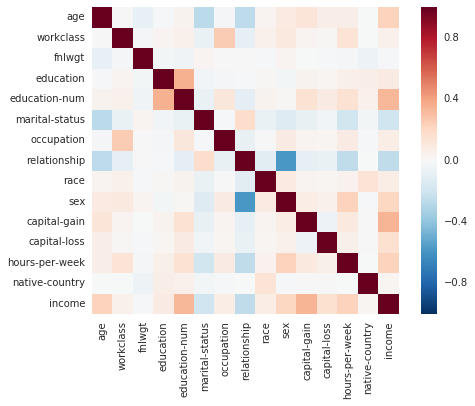

In [138]:
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

Podemos perceber no gráfico acima e na tabela abaixo que os atributos *education* e *education_num* possuem correlação muito alta.

In [139]:
original_data[["education", "education-num"]].head(10)

,education,education-num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


Como pode ser visto acima, as duas colunas representam as mesmas características, mas codificadas como string e número. Não precisamos das duas e, por isso, podemos remover uma delas. Vamos manter *education-num* já que os seus valores são numéricos e ordenados, ou seja, quanto maior o valor de *education-num* maior é o nível educacional da pessoa. Essa informação pode ser importante para vários algoritmos de Machine Learning.

In [140]:
del encoded_data["education"]

A maior parte dos algoritmos de Machine Learning requer padronização do conjunto de dados. Eles podem se comportar de forma inesperada se algumas features não tiver distribuição normalizada dos dados. Por isso, padronizamos a entrada com o StandardScaler.

In [141]:
#Prepara os dados
y_all = encoded_data['income']
X_all = encoded_data.drop(['income'], axis=1)

#Padroniza os dados
X_all_std = preprocessing.StandardScaler().fit_transform(X_all)

## Construção do classificador

Na construção do modelo, primeiro temos que separar a base de treino para não gerar overfitting, onde o modelo se ajusta muito bem ao conjunto de dados anteriormente observado, mas se mostra ineficaz para prever novos resultados, que é nosso objetivo nesse problema.

In [142]:
#Separa os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_all_std, y_all, train_size=0.70, random_state=100)

Agora que temos a base de dados de treinamento e teste, podemos executar os algoritmos de classificação. Existem diversos algoritmos de aprendizado [supervisionado](http://scikit-learn.org/stable/supervised_learning.html) e [não supervisionado](http://scikit-learn.org/stable/unsupervised_learning.html) no site do **scikit-learn**.

### [Regressão Logística](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
O primeiro modelo analisado é a regressão logística que permite prever valores em relação a uma variável categórica, frequentemente binária, a partir de uma série de variáveis explicativas contínuas e/ou binárias. 


In [143]:
cls = linear_model.LogisticRegression()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

**Para avaliar o nosso modelo, usamos a métrica F1. Quanto MAIOR o valor desta métrica, MELHOR é o modelo.**.

In [144]:
print "F1 score: %f" % skl.metrics.f1_score(y_test, y_pred)

F1 score: 0.561140


O resultado da classificação pode ser vista no gráfico de calor abaixo, onde é possível visualizar o número de casos onde o modelo indicou resultados diferentes do correto. 

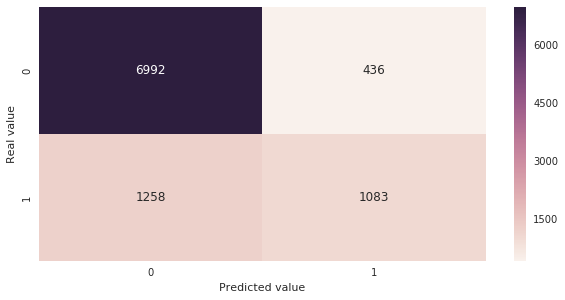

In [145]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.show()

Vimos que o F1 score não tem um valor alto. Para tentar melhorar o modelo, podemos primeiro visualizar quais atributos contribuiram de forma negativa e positiva para a predição.
Como pode ser visto no gráfico abaixo, as features *education-num*, *capital-gain* e *age* tem impacto positivo no modelo, enquanto *marital-status* e *relationship* tem impacto negativo.

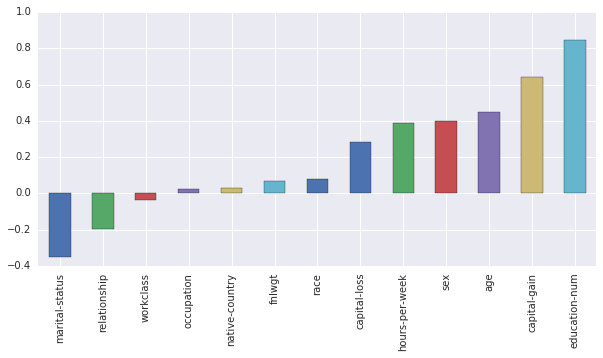

In [146]:
coefs = pd.Series(cls.coef_[0], index=X_all.columns).sort_values()
plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

Essa abordagem prejudica o modelo já que estamos colocando uma ordem arbitrária em nossas classes. Por exemplo, codificamos *relationship* como um número entre 1 e 5 e o modelo de Regressão Logística interpreta esses valores como variáveis contínuas e os coloca em uma função de otimização. Com isto diferentes classes terão diferentes pesos em nosso modelo, o que não é correto. Cada classe tem, teoricamente, o mesmo peso das outras classes. Para resolver este problema, podemos binarizar as features, ou seja, gerar todas as classes de cada feature e colocar tudo como 0 e 1. Isso é denominado *Feature binarization*. Neste tutorial iremos utilizar *Florestas Aleatórias* ou *Random Forest* para resolver este problemas, já que estas conseguem trabalhar com variáveis categorizadas.

### [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
Na área de Machine Learning espera-se que a combinação dos resultados de vários classificadores apresente melhor desempenho e maior convicção a tomada de decisão do que apenas um classificador. O algoritmo Random Forest (RF) é um termo geral para métodos de ensemble utilizando classificadores do tipo árvore. A RF constrói uma grande quantidade de árvores de decisão para fora do sub-conjunto de dados a partir de um treinamento único definido. Tal treinamento é realizado usando *bagging*. A utilização de bagging no treinamento além de reduzir a variância ajuda a evitar o overfitting. Este procedimento extrai casos aleatoriamente a partir de conjuntos de dados de treinamento originais e os conjuntos são usados para construir cada uma das árvores de decisão que compõe a RF. A RF constrói sua decisão por meio da contagem dos votos dos componentes preditores em cada classe e, em seguida, seleciona a classe vencedora em termos de número de votos acumulados. Para rodar o Random Forest, basta executar o código abaixo:

F1 score: 0.650682


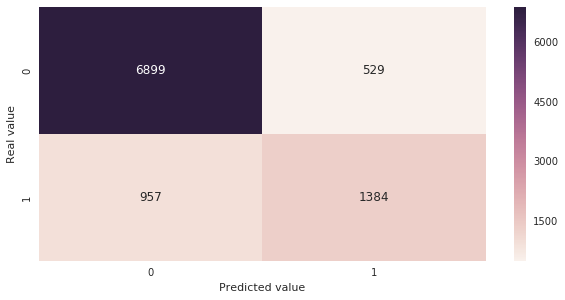

In [147]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

print "F1 score: %f" % skl.metrics.f1_score(y_test, y_pred)

cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.show()

Podemos ver acima que o score aumentou consideravemente com o uso do Random Forest. Como pode ser visto, o uso do modelo de Machine Learning correto de acordo com os dados pode fazer toda a diferença! Neste caso com variáveis categóricas, o uso de árvores de decisão é melhor por lidar melhor com este tipo de variável.